# Updraft-downdraft coupling

Thomas Schanzer  
January 2022

In this notebook we explore approaches to coupling downdrafts to updrafts in our scheme. After a review of relevant literature, we have formulated the following conclusions and questions:
- Updrafts should trigger downdrafts by the evaporation of precipitation (Windmiller et al., Cotton et al. 2011, Knupp and Cotton 1985)
    - The precipitation can descend from higher levels (Knupp and Cotton 1985)
- Precipitation-driven downdrafts should be initiated at low levels (Torri and Kuang 2016, Cotton et al. 2011, Knupp and Cotton 1985)
    - Torri and Kuang 2016: below ~2.5 km, peak around 1 km
    - Barnes and Garstang 1982 (in Knupp and Cotton 1985): near or below 750 mbar
    - Knupp and Cotton 1985: 2-5 km or 1.5-4.0 km
- Downdrafts could initiate at or below the level of minimum theta-e (Sud and Walker 1993, Zipser 1969 in Cotton et al. 2011)
- Since precipitation-associated downdrafts usually only exist at low levels, we need to consider other initiation mechanisms that generate elevated updrafts (Knupp and Cotton 1985)
    - Elevated downdrafts could be generated by overshooting updrafts (Cotton et al. 2011, Knupp and Cotton 1985)
- Can we model up-down downdrafts, whose air was previously much lower than the initiation level? (Cotton et al. 2011)
- Could averaging an ensemble of downdrafts (and/or updrafts) with a range of deterministically or stochastically chosen parameters give more realistic results, given the wide variation in updraft properties and their high correlation with entrainment history, as found by Romps and Kuang (2010)?
- We should consider a way to have downdraft velocity depend on updraft velocity (Windmiller et al.)
    - How do we achieve this in a physically plausible way, without making artificial and arbitrary adjustments?
    
We therefore explore the following possibilities in this notebook:
1. A downdraft initiated by the cumulative precipitation falling out of an updraft within a layer of finite width, with a low initiation level determined by either:
    1. The precipitation profile
    2. The environmental $\theta_e$ profile
2. A downdraft initialised with the properties of an overshooting updraft at a high level

In all cases we will vary the parameters that control updraft and downdraft propagation, namely entrainment and detrainment rates, drag and the LWC threshold for precipitation. In light of the findings of Romps and Kuang (2010), we will not pay as much attention to the initial updraft conditions, but rather prescribe typical values.

**References**
- Cotton, W. R., Bryan, G. H., & Van den Heever, S. C. (2011). *Storm and cloud dynamics : the dynamics of clouds and precipitating mesoscale systems* (2nd ed.). Burlington, MA: Academic Press.
- Knupp, K. R., & Cotton, W. R. (1985). Convective cloud downdraft structure: An interpretive survey. *Reviews of Geophysics*, **23**(2), 183–215. https://doi.org/10.1029/RG023i002p00183
- Romps, D. M., & Kuang, Z. (2010). Nature versus nurture in shallow convection. *Journal of the Atmospheric Sciences*, **67**(5), 1655–1666. https://doi.org/10.1175/2009JAS3307.1
- Sud, Y. ., & Walker, G. (1993). A rain evaporation and downdraft parameterization to complement a cumulus updraft scheme and its evaluation using GATE data. *Monthly Weather Review*, **121**(11), 3019–3039. https://doi.org/10.1175/1520-0493(1993)1212.0.CO;2
- Torri, G., & Kuang, Z. (2016). A Lagrangian study of precipitation-driven downdrafts. *Journal of the Atmospheric Sciences*, **73**(2), 839–854. https://doi.org/10.1175/JAS-D-15-0222.1
- Windmiller, J., Bao, J., Sherwood, S. C. & Schanzer, T. D. (in preparation). Downdrafts in a global storm resolving model.

In [238]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import pandas as pd
from scipy.interpolate import interp1d
import sys
import shelve

import metpy.calc as mpcalc
from metpy.units import units

from dparcel.thermo import (saturation_specific_humidity,
                            equivalent_potential_temperature)
sys.path.append('../convection_scheme')
from thermal_generator import ThermalGenerator

In [3]:
file = ('test_soundings/48698 WSSS Singapore Observations '
        'at 00Z 01 Dec 2021.txt')
sounding = pd.read_fwf(file, usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure_raw = sounding[:2:-1,0]
height_raw = sounding[:2:-1,1]
temperature_raw = sounding[:2:-1,2]
dewpoint_raw = sounding[:2:-1,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], 5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)
generator = ThermalGenerator(pressure, height, temperature, specific_humidity)

## Low-level precipitation-driven downdrafts

In [202]:
%%time
# updraft parameters
i_init_up = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init_up], temperature[i_init_up])
     - specific_humidity[i_init_up]
)
l_initial = 0*units.dimensionless
l_crit_all = [1e-3, 2e-3, 3e-3]*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
rate_all = [0.1, 0.25, 0.5]*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

rate_all, l_crit_all = np.meshgrid(rate_all, l_crit_all)
rate_all = rate_all.ravel()
l_crit_all = l_crit_all.ravel()
z_init_down_all = []
z_precip_top_all = []
max_velocity_all = []
min_height_all = []
for rate, l_crit in zip(rate_all, l_crit_all):
    sys.stdout.write(
        'epsilon = {:.2f}/km, l_crit = {:.1f} g/kg:\n'
        ''.format(rate.m, l_crit.m*1e3))
    updraft = generator.updraft(
        i_init_up, t_pert, q_pert, l_initial, w_initial,
        rate, dnu_db, drag, l_crit)

    # downdraft parameters:
    # downdraft may initiate anywhere the updraft reaches that is
    # below 4 km and above 500 m
    i_init_down_min = np.min(
        np.argwhere(~np.isnan(updraft.velocity) & (height <= 4000*units.meter))
    )
    i_init_down_max = np.max(np.argwhere(height >= 500*units.meter))
    i_init_down = range(i_init_down_min, i_init_down_max+1, 5)
    z_init_down = height[i_init_down_min:i_init_down_max+1:5]
    # the top of the precipitating layer must be somewhere the updraft
    # reaches and where there is nonzero precipitation
    i_precip_top_min = np.min(
        np.argwhere(~np.isnan(updraft.velocity) & (height <= 8000*units.meter))
    )
    i_precip_top_max = np.max(np.argwhere(updraft.precipitation > 0))
    i_precip_top = range(i_precip_top_min, i_precip_top_max+1, 5)
    z_precip_top = height[i_precip_top_min:i_precip_top_max+1:5]

    # result arrays
    max_velocity = np.full((len(i_init_down), len(i_precip_top)), np.nan)
    max_velocity *= units.meter/units.second
    min_height = np.full((len(i_init_down), len(i_precip_top)), np.nan)
    min_height *= units.meter

    valid_entries = np.atleast_2d(i_init_down).T >= np.atleast_2d(i_precip_top)
    i_valid = np.argwhere(valid_entries)[:,0]
    j_valid = np.argwhere(valid_entries)[:,1]
    n_calc = np.sum(valid_entries)
    n_done = 0
    for i, j in zip(i_valid, j_valid):
        n_done += 1
        sys.stdout.write(f'\r    Calculation {n_done} of {n_calc}    ')
        # sum the precipitation from the chosen levels, weighted
        # by the fractional mass remaining at each level since
        # the precipitation reported for the updraft is per unit mass
        # remaining, not per unit original mass
        total_precip = np.nansum((
            updraft.precipitation*updraft.m_remaining
        )[i_precip_top[j] : i_init_down[i] + 1])
        downdraft = generator.downdraft(
            i_init_down[i], total_precip, w_initial, rate, dnu_db, drag)
        max_velocity[i,j] = np.nanmin(downdraft.velocity)
        min_height[i,j] = height[
            np.max(np.argwhere(~np.isnan(downdraft.velocity)))
        ]
    z_init_down_all.append(z_init_down)
    z_precip_top_all.append(z_precip_top)
    max_velocity_all.append(max_velocity)
    min_height_all.append(min_height)
    sys.stdout.write('\n')

epsilon = 0.10/km, l_crit = 1.0 g/kg:
    Calculation 220 of 220    
epsilon = 0.25/km, l_crit = 1.0 g/kg:
    Calculation 220 of 220    
epsilon = 0.50/km, l_crit = 1.0 g/kg:
    Calculation 208 of 208    
epsilon = 0.10/km, l_crit = 2.0 g/kg:
    Calculation 218 of 218    
epsilon = 0.25/km, l_crit = 2.0 g/kg:
    Calculation 218 of 218    
epsilon = 0.50/km, l_crit = 2.0 g/kg:
    Calculation 192 of 192    
epsilon = 0.10/km, l_crit = 3.0 g/kg:
    Calculation 211 of 211    
epsilon = 0.25/km, l_crit = 3.0 g/kg:
    Calculation 211 of 211    
epsilon = 0.50/km, l_crit = 3.0 g/kg:
    Calculation 185 of 185    
CPU times: user 16min 40s, sys: 7.9 s, total: 16min 48s
Wall time: 16min 58s


In [222]:
theta_e = equivalent_potential_temperature(pressure, temperature, specific_humidity)
z_min_theta_e = height[np.argmin(theta_e)]

z_max_precip = np.zeros(rate_all.size)*units.meter
for i, (rate, l_crit) in enumerate(zip(rate_all, l_crit_all)):
    updraft = generator.updraft(
        i_init_up, t_pert, q_pert, l_initial, w_initial,
        rate, dnu_db, drag, l_crit)
    
    precip = updraft.precipitation*updraft.m_remaining
    precip[height > 4000*units.meter] = np.nan
    z_max_precip[i] = height[np.nanargmax(precip)]

In [263]:
with shelve.open('coupling_figures_data/precip_driven_data') as db:
    db['z_precip_top_all'] = z_precip_top_all
    db['z_init_down_all'] = z_init_down_all
    db['max_velocity_all'] = max_velocity_all
    db['min_height_all'] = min_height_all
    print(list(db.keys()))

['min_height_all', 'z_precip_top_all', 'z_init_down_all', 'max_velocity_all']


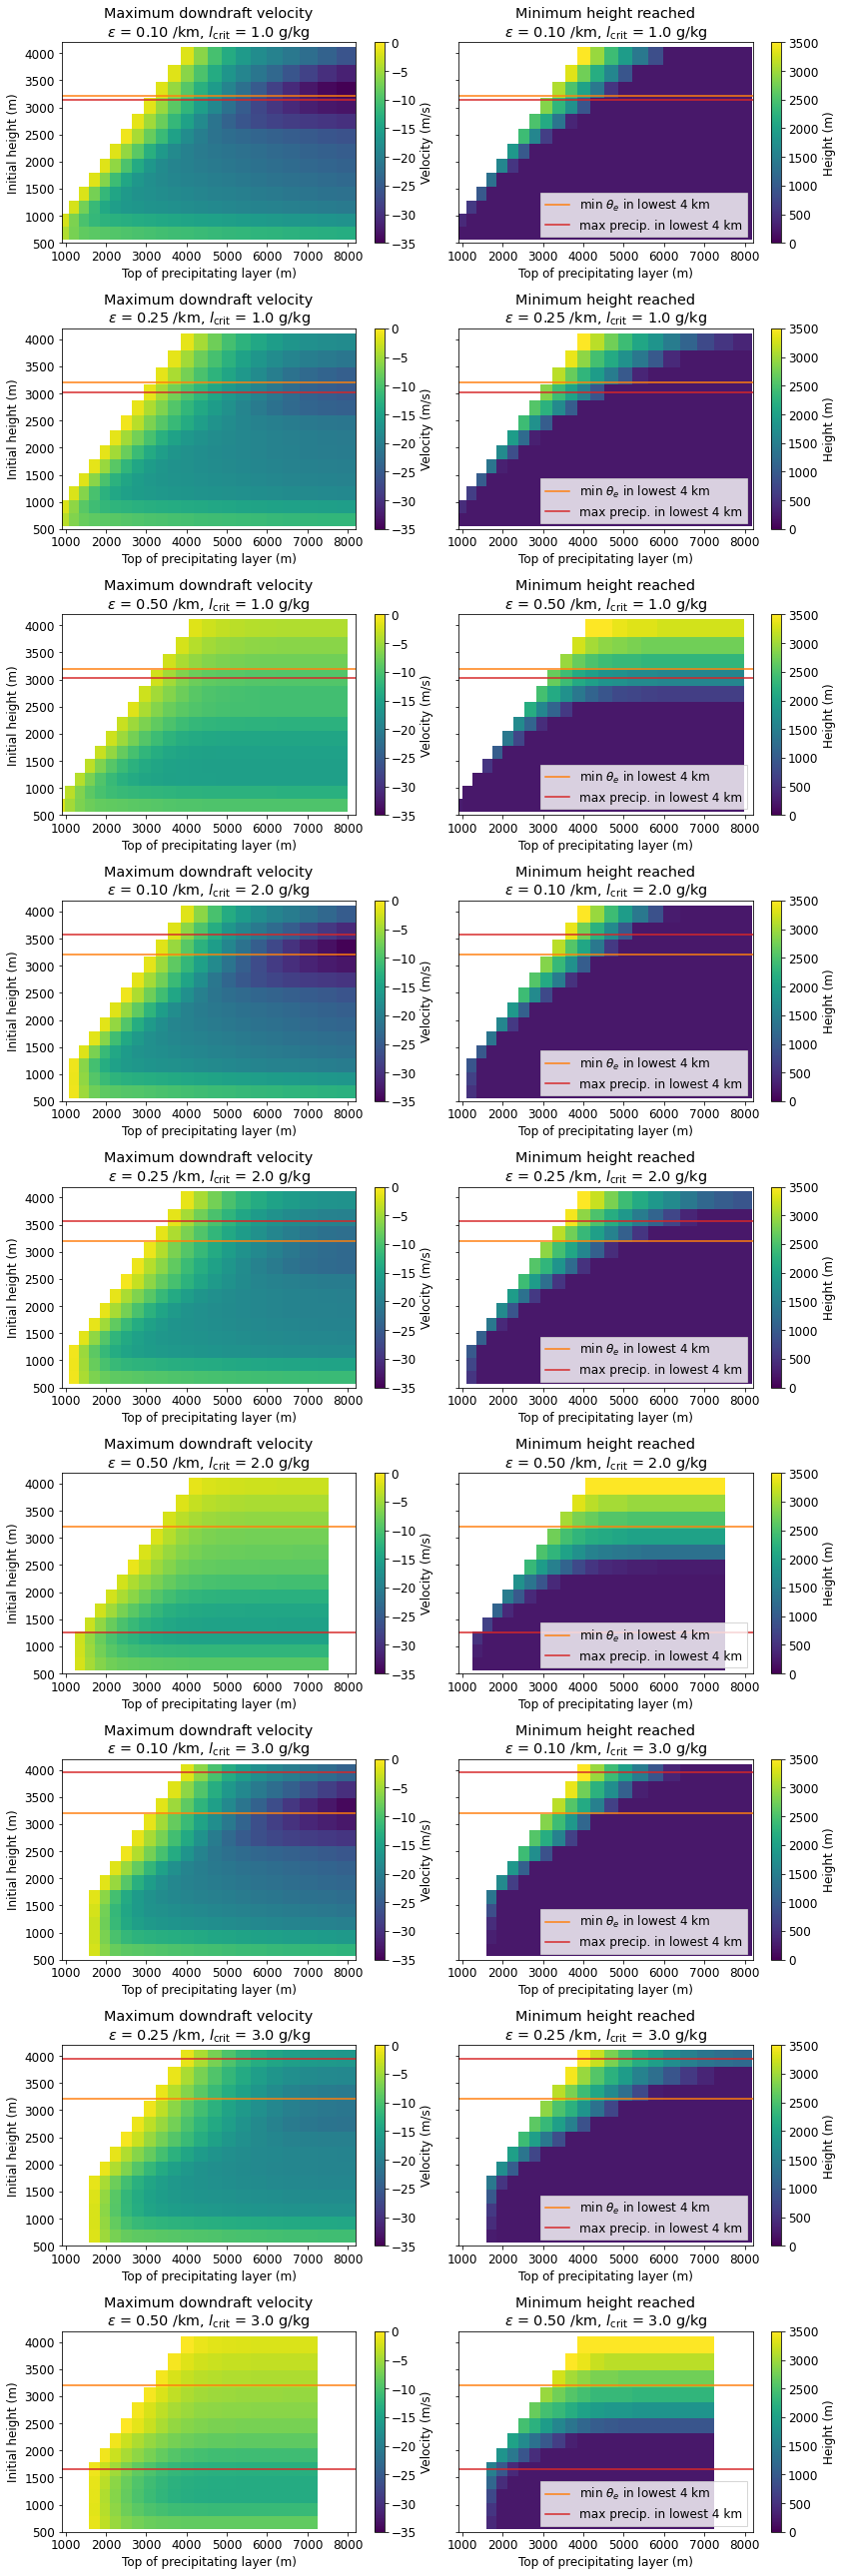

In [265]:
fig, axes = plt.subplots(rate_all.size, 2, figsize=(12,4*rate_all.size))
for i, (rate, l_crit) in enumerate(zip(rate_all, l_crit_all)):
    mesh = axes[i,0].pcolormesh(
        z_precip_top_all[i], z_init_down_all[i], max_velocity_all[i],
        shading='nearest')
    mesh.set_clim(-35, 0)
    cbar = fig.colorbar(mesh, ax=axes[i,0])
    cbar.set_label('Velocity (m/s)')
    axes[i,0].set(xlabel='Top of precipitating layer (m)',
                ylabel='Initial height (m)',
                title='Maximum downdraft velocity\n'
                      '$\epsilon$ = {:.2f} /km, '
                      '$l_\mathrm{{crit}}$ = {:.1f} g/kg'
                      ''.format(rate.m, l_crit.m*1e3))
    axes[i,0].axhline(z_min_theta_e, color='tab:orange')
    axes[i,0].axhline(z_max_precip[i], color='tab:red')
    axes[i,0].set_xlim(900, 8200)
    axes[i,0].set_ylim(500, 4200)
    
    mesh = axes[i,1].pcolormesh(
        z_precip_top_all[i], z_init_down_all[i], min_height_all[i],
        shading='nearest')
    mesh.set_clim(0, 3500)
    cbar = fig.colorbar(mesh, ax=axes[i,1])
    cbar.set_label('Height (m)')
    axes[i,1].set(xlabel='Top of precipitating layer (m)',
                  ylabel='',
                  title='Minimum height reached\n'
                        '$\epsilon$ = {:.2f} /km, '
                        '$l_\mathrm{{crit}}$ = {:.1f} g/kg'
                        ''.format(rate.m, l_crit.m*1e3))
    axes[i,1].set_yticklabels([])
    axes[i,1].axhline(z_min_theta_e, color='tab:orange',
                      label=r'min $\theta_e$ in lowest 4 km')
    axes[i,1].axhline(z_max_precip[i], color='tab:red',
                      label='max precip. in lowest 4 km')
    axes[i,1].legend(loc='lower right', fancybox=False)
    axes[i,1].set_xlim(900, 8200)
    axes[i,1].set_ylim(500, 4200)

fig.tight_layout()
fig.savefig('coupling_figures_data/precip_driven.png', dpi=300,
            facecolor='w', bbox_inches='tight')

## Elevated downdrafts from overshooting updrafts